In [12]:
import sympy as sp
import networkx as nx
import numpy as np
from math import factorial

import linearframework.graph_operations as g_ops
import linearframework.ca_recurrence as ca
import linearframework.linear_framework_results as lfr

## TODO

- [ ] splitting probability tests
- [ ] conditional mean first passage times
- [ ] refactor to remove the need for edge_to_weight when calculating symbolic expressions

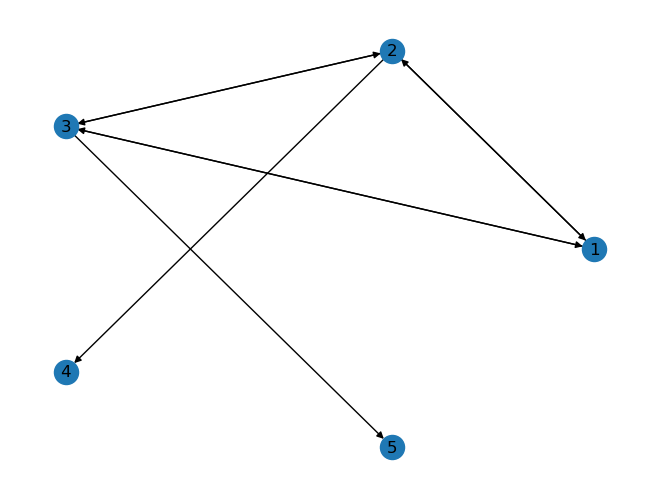

In [13]:
k3_edge_to_weight = {
    ('1', '2'): 1,
    ('1', '3'): 2,
    ('2', '1'): 3,
    ('2', '3'): 4,
    ('3', '1'): 5,
    ('3', '2'): 6,
    ('2', '4'): 7,
    ('3', '5'): 8
}

# k3_edge_to_weight = {
#     ('1', 'p_1'): 1.1774154985086274,
#     ('p_1', '1'): 0.007327531200248026,
#     ('1', 'p_2'): 504.4082462406216,
#     ('p_2', '1'): 491.9224950758322,
#     ('p_1', 'p_2'): 0.00047413513077016573,
#     ('p_2', 'p_1'): 0.07429998260135516,
#     ('1', 'p_bar_1'): 1.1774154985086274,
#     ('p_bar_1', '1'): 0.07327531200248026,
#     ('1', 'p_bar_2'): 504.4082462406216,
#     ('p_bar_2', '1'): 4919.224950758322,
#     ('p_bar_1', 'p_bar_2'): 0.00047413513077016573,
#     ('p_bar_2', 'p_bar_1'): 0.07429998260135516
#     }

k3 = g_ops.dict_to_graph(k3_edge_to_weight)

n = len(k3.nodes)

k3_edge_to_sym = g_ops.edge_to_sym_from_edge_to_weight(k3_edge_to_weight)

k3_sym_lap = ca.generate_sym_laplacian(k3, k3_edge_to_sym)

k3_Q_n_minus_2 = ca.get_sigma_Q_k(k3_sym_lap, 1)[1]

nx.draw(k3, pos=nx.circular_layout(k3), with_labels=True)

Implementing splitting probability

In [26]:
def splitting_probability(edge_to_sym, terminal_vertices, source, target):
    """Calculates the splitting probability of the graph represented by edge_to_sym from source to target.

    Args:
        edge_to_sym (dict[tuple[str]: sympy.core.symbol.Symbol]): dictionary with the form {('v_1', 'v_2): l_i} 
        terminal_vertices (list[str]): list of the ids of the terminal vertices in the graph represented by edge_to_sym
        source (str): vertex id of source of splitting probability
        target (str): vertex id of target of splitting probability

    Returns:
        sympy.core.mul.Mul: sympy expression of splitting probability
    """
    if not isinstance(edge_to_sym, dict):
        raise NotImplementedError("edge_to_sym must be a dictionary of edges to sympy symbols in the form {('v_1, 'v_2'): l_i} where l_i is a sympy symbol and 'v_1' and 'v_2' are the ids of vertices.")
    for key in edge_to_sym.keys():
        if not isinstance(key, tuple) or not isinstance(key[0], str) or not isinstance(key[1], str) or len(key) != 2:
            raise NotImplementedError("edge_to_sym must be a dictionary of edges to sympy symbols in the form {('v_1, 'v_2'): l_i} where l_i is a sympy symbol and 'v_1' and 'v_2' are the ids of vertices.")
        if not isinstance(edge_to_sym[key], sp.core.symbol.Symbol):
            raise NotImplementedError("edge_to_sym must be a dictionary of edges to sympy symbols in the form {('v_1, 'v_2'): l_i} where l_i is a sympy symbol and 'v_1' and 'v_2' are the ids of vertices.")
    if not isinstance(terminal_vertices, list):
        raise NotImplementedError("terminal vertices must be a list of the string ids of the terminal vertices in edge_to_sym")
    graph = nx.DiGraph()
    for vertex in terminal_vertices:
        if vertex not in list(graph.nodes()):
            raise NotImplementedError("terminal vertices must be a list of the string ids of the terminal vertices in edge_to_sym")
    if source not in list(graph.nodes):
        raise NotImplementedError("source must a be a vertex of the graph represented by edge_to_sym")
    if target not in list(graph.nodes):
        raise NotImplementedError("target must a be a vertex of the graph represented by edge_to_sym")
    
    graph.add_edges_from(edge_to_sym.keys())
    sym_lap = ca.generate_sym_laplacian(graph, edge_to_sym)
    n = sym_lap.rows
    m = len(terminal_vertices)
    Q_n_minus_2 = ca.get_sigma_Q_k(sym_lap, n-m)[1]
    denominator = lfr.sum_sym_weights_jq_roots_ij_path(graph, sym_lap, Q_n_minus_2, terminal_vertices, target, target)
    numerator = lfr.sum_sym_weights_jq_roots_ij_path(graph, sym_lap, Q_n_minus_2, terminal_vertices, source, target)
    return numerator / denominator

type(splitting_probability(k3_edge_to_sym, ['4', '5'], '1', '5'))

sympy.core.mul.Mul

In [29]:
type(list(k3_edge_to_sym.values())[0])

sympy.core.symbol.Symbol